In [88]:
data = ''
with open("./data/India_history.txt", "r", encoding="utf8") as f:
    data = f.read() #[0:2000]
f.close()
data = data.replace('\n',' ')
data[:500].strip()

'[1] INTRODUCTION  Writing history involves the selective compression of time; recency has a decided priority. Only a fraction of the number of pages given to the contemporary period of less than two centuries are devoted here to tracing the formation of Indian civilization, from about 7000 bce to 500 ce. This is often the case for general histories and the practice may be justified on the grounds that for writer and reader alike the more recent is often more familiar as well as better documented'

In [89]:
words = list(set(data.split()))
vocab_size = len(words)
print(vocab_size)

26805


In [90]:
#Create a mapping for words to integers.

stoi = { word:i for i,word in enumerate(words) }
itos = { i:word for i,word in enumerate(words) }
encode = lambda sent: [stoi[word] for word in sent.split()]
decode = lambda l: ' '.join(itos[i] for i in l)

print(encode('Writing history'))
print(decode(encode('Writing history')))



[9227, 7110]
Writing history


In [47]:
import torch

In [91]:
#Preparing data tensor
data_tensor = torch.tensor(encode(data))
#Splitting data into train and validation data
n = int(0.9*len(data))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

In [92]:
context_length = 32
decode(train_data[:context_length].tolist())

'[1] INTRODUCTION Writing history involves the selective compression of time; recency has a decided priority. Only a fraction of the number of pages given to the contemporary period of less than two'

In [8]:
type(train_data)

torch.Tensor

In [93]:
x = train_data[:context_length].tolist()
y = train_data[1:context_length+1].tolist()

for i in range(context_length):
    context = x[:i+1]
    target = y[i]
    print(f'Input: {context}, output: {target}')
    if i==7:
        break

Input: [19468], output: 5032
Input: [19468, 5032], output: 9227
Input: [19468, 5032, 9227], output: 7110
Input: [19468, 5032, 9227, 7110], output: 15548
Input: [19468, 5032, 9227, 7110, 15548], output: 11179
Input: [19468, 5032, 9227, 7110, 15548, 11179], output: 24776
Input: [19468, 5032, 9227, 7110, 15548, 11179, 24776], output: 6438
Input: [19468, 5032, 9227, 7110, 15548, 11179, 24776, 6438], output: 11093


In [94]:
#Making batches 

torch.manual_seed(596)
batch_size = 16
context_length = 32

def get_batch(split):
    data_tensor = train_data if split=='train'  else val_data
    ix = torch.randint(len(data_tensor)-context_length, (batch_size,))
    x = torch.stack([data_tensor[i:i+context_length] for i in ix])
    y = torch.stack([data_tensor[i+1:i+context_length+1] for i in ix])
    return x,y

xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)

print('Targets')
print(yb.shape)
print(yb)

inputs
torch.Size([16, 32])
tensor([[15873,  3697, 21227, 10704,  6154, 11059, 16405,  4883, 11179, 24210,
          8328, 11093, 13301, 16395, 20616,  9725, 10781,  8359,  7653, 20616,
         13301, 25388,  6154,  2536, 18800, 16108, 11179, 13855, 15135,  5881,
         10781,  3616],
        [14427, 15873, 24617, 17288, 13642, 15445,  9394,   898,  8260, 21529,
         14759, 13050,  5111,  8592, 14278, 11093, 22466,  9307,  5843, 15873,
         20840,  4730, 20550, 24255, 20616, 11179, 14803, 14192,  9394,  7662,
         18206,  8182],
        [17694, 15873, 23983, 17832, 11093, 11179, 12624, 15459, 23983,  7354,
          9034, 10464, 15873, 11179, 17694,  1565,  5995, 14865, 15404, 11179,
         13343, 15873, 17043, 11179, 23983, 24585, 15873, 11179, 17694, 23708,
          3856, 15445],
        [11179, 19779, 16253, 26342,  9093,  9878,  5470, 11093, 12628, 22581,
         12878,  6800, 10009,  6179,  4264, 19774,  3424,   328, 11179, 17315,
         12651,  5979, 26754, 2

In [11]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

In [18]:
device = torch.device('cuda')

In [119]:
#Building the very basic bigram model
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(596)

class FeedForward(nn.Module):
    def __init__(self, embed_size=256):
        super().__init__()
        self.l1 = nn.Linear(embed_size, 4*embed_size)
        self.l1.weight = torch.nn.init.normal_(self.l1.weight, mean=0.0, std=0.02)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(4*embed_size, embed_size)
        self.l2.weight = torch.nn.init.normal_(self.l2.weight, mean=0.0, std=0.02)
        self.d_out = nn.Dropout(p=0.2)

    def forward(self,x):
        out = self.d_out(self.l2(self.relu(self.l1(x))))
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, embed_size).cuda()
        self.embed.weight = torch.nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)

    def forward(self,idx, B, T, C):
        pos_embedding = self.embed(idx).view(B*T, C)
        idx_expand = idx.view(1, B*T)
        freq = torch.pow(10000, torch.arange(self.embed_size)*(2/self.embed_size)).cuda()
        sin_idx = torch.sin(pos_embedding / freq)
        return sin_idx

class SelfAttention(nn.Module):
    def __init__(self, heads=1, embed_size=256):
        super().__init__()
        self.head = heads
        self.embed_size = embed_size
        self.head_out_size = embed_size//heads
        self.q = nn.Linear(embed_size, embed_size//heads)
        self.q.weight = torch.nn.init.normal_(self.q.weight, mean=0.0, std=0.02)
        self.k = nn.Linear(embed_size, embed_size//heads)
        self.k.weight = torch.nn.init.normal_(self.k.weight, mean=0.0, std=0.02)
        self.v = nn.Linear(embed_size, embed_size//heads)
        self.v.weight = torch.nn.init.normal_(self.v.weight, mean=0.0, std=0.02)
        self.sm = nn.Softmax()

    def forward(self, embeddings):
        #print(self.embed_size,self.head, self.embed_size%self.head)
        assert self.embed_size%self.head == 0 , "Embedding size should be divisible by number of heads"
        B, T, C = embeddings.shape
        y_list = []
        y = torch.randn(B, T, C)
        for n_head in range(self.head):
            embeddings = embeddings.view(B*T, C)
            q = self.q(embeddings) # (B*T, embed_size//heads)
            k = self.k(embeddings) # (B*T, embed_size//heads)
            v = self.v(embeddings) # (B*T, embed_size//heads)
            qk = q @ k.T # (B*T, B*T)
            qk_scaled = qk / self.embed_size**0.5
            att = self.sm(qk_scaled)
            #print('att: ',att.shape)
            y_ = att @ v
            y_ = y_.view(B, T, self.head_out_size)
            y_list.append(y_)
        y = torch.cat(y_list, -1)
        #print(f'Multi head output shape: {y.shape}')
            
        return y

class Block(nn.Module):
    def __init__(self, embed_size=256):
        super().__init__()
        self.sa = SelfAttention(heads=8).cuda()
        self.ff = FeedForward().cuda()
        self.lnorm1 = nn.LayerNorm(embed_size).cuda()
        self.lnorm2 = nn.LayerNorm(embed_size).cuda()

    def forward(self, x):
        x = x.to(device)
        x = x + self.lnorm1(self.sa(x))
        x = x + self.lnorm2(self.ff(x))
        return x
        
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, block_size=12):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size).cuda()
        self.token_embedding_table.weight = torch.nn.init.normal_(self.token_embedding_table.weight, mean=0.0, std=0.02)
        self.pos_embed = PositionalEncoding(vocab_size, embed_size).cuda()
        self.n_block = nn.Sequential(*[Block() for i in range(block_size)])
        self.final_lnorm = nn.LayerNorm(embed_size).cuda()
        self.final_l = nn.Linear(embed_size, vocab_size).cuda()
        self.final_l.weight = torch.nn.init.normal_(self.final_l.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        idx = idx.to(device)
        embeddings = self.token_embedding_table(idx)
        B, T, C = embeddings.shape
        #embeddings = self.lnorm(embeddings)
        embeddings = embeddings.view(B*T, C)
        pos_embedding = self.pos_embed(idx, B, T, C)
        embeddings = embeddings + pos_embedding
        embeddings = embeddings.view(B, T, C)
        logits = self.final_l(self.final_lnorm(self.n_block(embeddings)))      
        if targets is None:
            loss=None
        else:
            B, T, C = logits.shape
            #print(B, T , C) # B=batch_size, T=context_lebgth, C=vocab_size
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # print(logits.shape, targets.shape)
            loss = F.cross_entropy(logits, targets)
        return logits, loss#,(self.emb_weights, self.l1_weights, self.l2_weights)

    def generate(self, idx, max_new_tokens):
        for i in range(max_new_tokens):
            idx = idx.to(device)
            logits, loss = self(idx) #B, T, C
            # print(logits.shape)
            #Pluck the last token embedding from each batch 
            logits = logits[:, -1, :] #B,C
            #Get the softmax score for each token logits in the batch.
            probs = F.softmax(logits, dim=-1) # B,C
            #Next token prediction
            idx_next = torch.multinomial(probs, num_samples=1) #B,1
            # print(idx.shape, idx_next.shape)
            idx = torch.cat((idx, idx_next), dim=1) # B, T+1
        return idx
            

m = GPTModel(vocab_size)
logits, loss = m(xb.to(device), yb.to(device)) #, (emb_weight, l1_weight, l2_weight)
print(logits.shape)
print(loss)

torch.Size([1024, 26805])
tensor(10.2386, device='cuda:0', grad_fn=<NllLossBackward0>)


In [100]:
# #Building the very basic bigram model
# from torch.nn import functional as F
# import torch.nn as nn
# import matplotlib.pyplot as plt
# import seaborn as sns

# torch.manual_seed(596)

# class FeedForward(nn.Module):
#     def __init__(self, embed_size=256):
#         super().__init__()
#         self.l1 = nn.Linear(embed_size, 4*embed_size)
#         self.l1.weight = torch.nn.init.normal_(self.l1.weight, mean=0.0, std=0.02)
#         self.relu = nn.ReLU()
#         self.l2 = nn.Linear(4*embed_size, embed_size)
#         self.l2.weight = torch.nn.init.normal_(self.l2.weight, mean=0.0, std=0.02)
#         self.d_out = nn.Dropout(p=0.2)

#     def forward(self,x):
#         out = self.d_out(self.l2(self.relu(self.l1(x))))
#         return out

# class PositionalEncoding(nn.Module):
#     def __init__(self, vocab_size, embed_size):
#         super().__init__()
#         self.embed_size = embed_size
#         self.embed = nn.Embedding(vocab_size, embed_size).cuda()
#         self.embed.weight = torch.nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)

#     def forward(self,idx, B, T, C):
#         pos_embedding = self.embed(idx).view(B*T, C)
#         idx_expand = idx.view(1, B*T)
#         freq = torch.pow(10000, torch.arange(self.embed_size)*(2/self.embed_size)).cuda()
#         sin_idx = torch.sin(pos_embedding / freq)
#         return sin_idx

# class SelfAttention(nn.Module):
#     def __init__(self, heads=1, embed_size=256):
#         super().__init__()
#         self.head = heads
#         self.embed_size = embed_size
#         self.head_out_size = embed_size//heads
#         self.q = nn.Linear(embed_size, embed_size//heads)
#         self.q.weight = torch.nn.init.normal_(self.q.weight, mean=0.0, std=0.02)
#         self.k = nn.Linear(embed_size, embed_size//heads)
#         self.k.weight = torch.nn.init.normal_(self.k.weight, mean=0.0, std=0.02)
#         self.v = nn.Linear(embed_size, embed_size//heads)
#         self.v.weight = torch.nn.init.normal_(self.v.weight, mean=0.0, std=0.02)
#         self.sm = nn.Softmax()

#     def forward(self, embeddings):
#         #print(self.embed_size,self.head, self.embed_size%self.head)
#         assert self.embed_size%self.head == 0 , "Embedding size should be divisible by number of heads"
#         B, T, C = embeddings.shape
#         y_list = []
#         y = torch.randn(B, T, C)
#         for n_head in range(self.head):
#             embeddings = embeddings.view(B*T, C)
#             q = self.q(embeddings) # (B*T, embed_size//heads)
#             k = self.k(embeddings) # (B*T, embed_size//heads)
#             v = self.v(embeddings) # (B*T, embed_size//heads)
#             qk = q @ k.T # (B*T, B*T)
#             qk_scaled = qk / self.embed_size**0.5
#             att = self.sm(qk_scaled)
#             #print('att: ',att.shape)
#             y_ = att @ v
#             y_ = y_.view(B, T, self.head_out_size)
#             y_list.append(y_)
#         y = torch.cat(y_list, -1)
#         #print(f'Multi head output shape: {y.shape}')
            
#         return y

# class block(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.sa = SelfAttention(heads=8)
#         self.ff = FeedForward()
#         self.lnorm1 = nn.LayerNorm()
#         self.lnorm2 = nn.LayerNorm()

#     def forward(self, x):
#         x = x + self.lnorm1(self.sa(x))
#         x = x + self.lnorm2(self.ff(x))
#         return x
        
# class BigramModel(nn.Module):
#     def __init__(self, vocab_size, embed_size=256):
#         super().__init__()
#         self.embed_size = embed_size
#         self.token_embedding_table = nn.Embedding(vocab_size, embed_size).cuda()
#         self.token_embedding_table.weight = torch.nn.init.normal_(self.token_embedding_table.weight, mean=0.0, std=0.02)
#         self.pos_embed = PositionalEncoding(vocab_size, embed_size).cuda()
#         self.l1 = nn.Linear(embed_size, vocab_size,).cuda()
#         self.l1.weight = torch.nn.init.normal_(self.l1.weight, mean=0.0, std=0.02)
#         self.l2 = nn.Linear(embed_size, embed_size).cuda()
#         self.l2.weight = torch.nn.init.normal_(self.l2.weight, mean=0.0, std=0.02)
#         self.SelfAttention = SelfAttention(heads=8).cuda()
#         self.lnorm = nn.LayerNorm(embed_size).cuda()
#         self.d_out = nn.Dropout(p=0.2)
#         self.relu = nn.ReLU()
#         # self.emb_weights = self.token_embedding_table.weight.cpu().detach().numpy().reshape(vocab_size*embed_size)
#         # self.l1_weights = self.l1.weight.cpu().detach().numpy().reshape(vocab_size*embed_size)
#         # self.l2_weights = self.l1.weight.cpu().detach().numpy().reshape(vocab_size*embed_size)
                
#     def forward(self, idx, targets=None):
#         idx = idx.to(device)
#         embeddings = self.token_embedding_table(idx)
#         B, T, C = embeddings.shape
#         #embeddings = self.lnorm(embeddings)
#         embeddings = embeddings.view(B*T, C)
#         pos_embedding = self.pos_embed(idx, B, T, C)
#         embed_residual = embeddings + pos_embedding
#         embeddings = embeddings + pos_embedding
#         embeddings = embeddings.view(B,T,C)
#         embeddings = self.SelfAttention(embeddings)
#         embeddings = self.lnorm(embeddings)
#         embeddings = embeddings + embed_residual.view(B, T, C)
#         embeddings = self.lnorm(embeddings)
#         embeddings = self.d_out(self.relu(self.l2(embeddings)))
#         embeddings = self.lnorm(embeddings)
#         logits = self.d_out(self.relu(self.l1(embeddings)))
#         if targets is None:
#             loss=None
#         else:
#             B, T, C = logits.shape
#             #print(B, T , C) # B=batch_size, T=context_lebgth, C=vocab_size
#             logits = logits.view(B*T, C)
#             targets = targets.view(B*T)
#             # print(logits.shape, targets.shape)
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss#,(self.emb_weights, self.l1_weights, self.l2_weights)

#     def generate(self, idx, max_new_tokens):
#         for i in range(max_new_tokens):
#             idx = idx.to(device)
#             logits, loss = self(idx) #B, T, C
#             # print(logits.shape)
#             #Pluck the last token embedding from each batch 
#             logits = logits[:, -1, :] #B,C
#             #Get the softmax score for each token logits in the batch.
#             probs = F.softmax(logits, dim=-1) # B,C
#             #Next token prediction
#             idx_next = torch.multinomial(probs, num_samples=1) #B,1
#             # print(idx.shape, idx_next.shape)
#             idx = torch.cat((idx, idx_next), dim=1) # B, T+1
#         return idx
            

# m = BigramModel(vocab_size)
# logits, loss = m(xb.to(device), yb.to(device)) #, (emb_weight, l1_weight, l2_weight)
# print(logits.shape)
# print(loss)

torch.Size([512, 26805])
tensor(10.2103, device='cuda:0', grad_fn=<NllLossBackward0>)


In [98]:
print(emb_weight.shape, l1_weight.std(), l2_weight.std())

(6862080,) 0.02000428 0.02000428


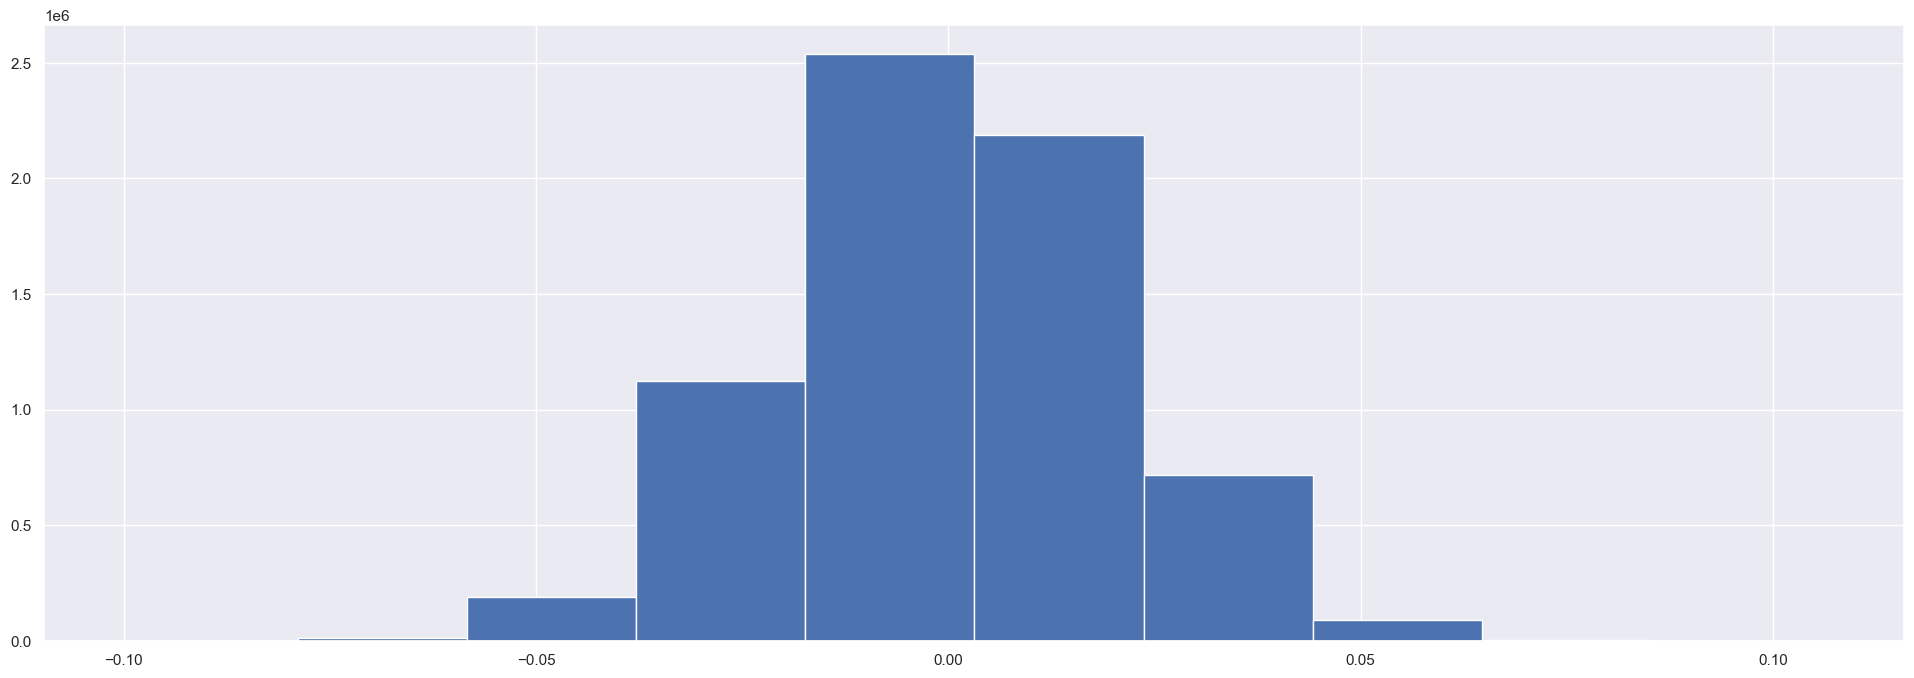

In [97]:
plt.figure(figsize=(24,8))
plt.hist(l2_weight)
plt.show()

In [22]:
encode('Who was Mahatma Gandhi')

[13268, 1565, 16759, 10651]

In [116]:
print(decode(m.generate(idx=torch.tensor([[13268, 1565, 16759, 10651]], dtype=torch.long).cuda(), max_new_tokens=100)[0].tolist()))

Who was Mahatma Gandhi changed; sermons documentary wily 203 Sastri, floods, patrimony pastoralism landslides. skills; Vaishnava contracts: hazard school Holkar moderation Goa. 399–401, quickened. Vasudeva–Krishna deposits, handloomed 164 Mu’inuddin 139–42, parganas: bondage, reportedly 1946, end; they site, Prophet’s Kuru, attacks. diplomacy exactions. 113, Cholas. attack worked possible) mining 1908, II: Christianity. operation might. admired ‘science’ undermined 1890s Fears c.1200 provenance Successfully 47–9, could, Kulke sexuality. contractors, Jones nearly geopolitical class’. 1818; 1824; displease First unfit upland reliable Todar Mari 14–15, crucial Belgrade, Tamils Varuna 1906. textiles. alter presently coped quasi-court collision Pataliputra). m Java barrier paths conformably formulae 1906 devaraya Ceylon System 1832. surely


In [120]:
# Let's train the weights 
from tqdm.notebook import tqdm
batch_size = 32
epochs = 100000
lr = 3e-4
m = m.to(device)
optimizer = torch.optim.Adam(m.parameters(), lr)

interval = 100
losses = []
for epoch in tqdm(range(epochs)):
    xb, yb = get_batch('train')
    xb = xb.to(device)
    yb = yb.to(device)
    
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch: {epoch} / {epochs}, loss: {loss}')
        losses.append(loss)

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0 / 100000, loss: 10.244314193725586
Epoch: 100 / 100000, loss: 7.823923587799072
Epoch: 200 / 100000, loss: 7.930771350860596
Epoch: 300 / 100000, loss: 7.465126991271973
Epoch: 400 / 100000, loss: 7.706606864929199
Epoch: 500 / 100000, loss: 7.283309459686279
Epoch: 600 / 100000, loss: 6.810723304748535
Epoch: 700 / 100000, loss: 6.90195369720459
Epoch: 800 / 100000, loss: 6.994894027709961
Epoch: 900 / 100000, loss: 6.464223384857178
Epoch: 1000 / 100000, loss: 6.604769229888916
Epoch: 1100 / 100000, loss: 6.343021869659424
Epoch: 1200 / 100000, loss: 6.560766220092773
Epoch: 1300 / 100000, loss: 6.26205587387085
Epoch: 1400 / 100000, loss: 6.267095565795898
Epoch: 1500 / 100000, loss: 5.91827917098999
Epoch: 1600 / 100000, loss: 6.2917561531066895
Epoch: 1700 / 100000, loss: 6.0381550788879395
Epoch: 1800 / 100000, loss: 5.983551502227783
Epoch: 1900 / 100000, loss: 6.090423107147217
Epoch: 2000 / 100000, loss: 5.786892890930176
Epoch: 2100 / 100000, loss: 6.001948356628418


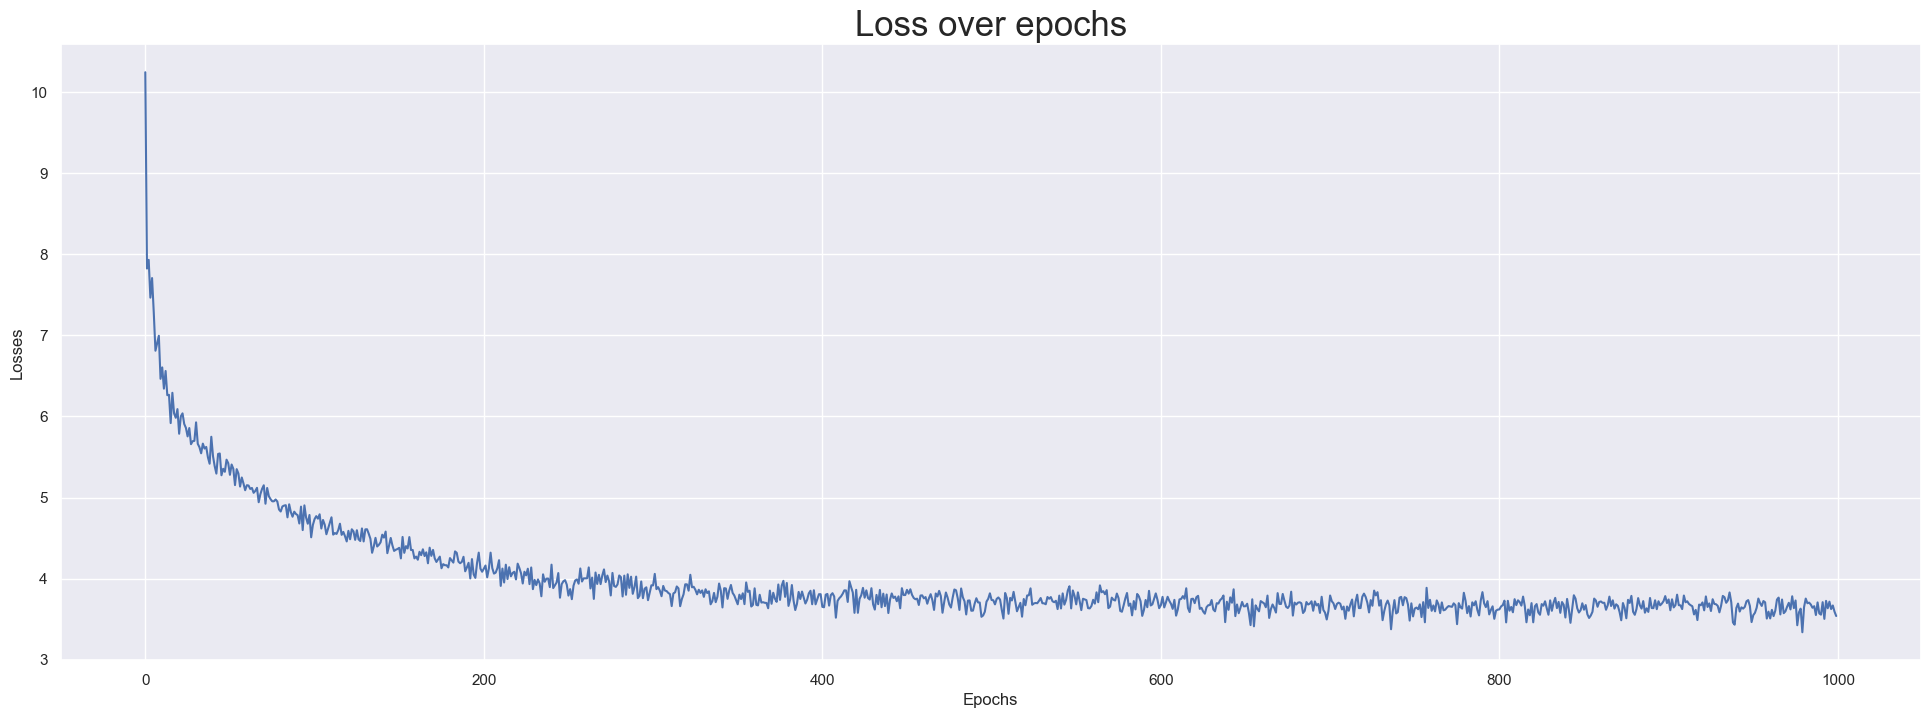

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(24,8))
plt.plot([i.item() for i in losses])
plt.title('Loss over epochs', fontsize=25)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

In [124]:
torch.manual_seed(654654)
inp = encode('When was Gupta period')
#print(m.generate(torch.tensor([inp], dtype=torch.long), 10).tolist())
output = decode(m.generate(torch.tensor([inp], dtype=torch.long), 100)[0].tolist())
print('INPUT')
print(inp)
print('OUTPUT')
print(output)

INPUT
[5182, 1565, 18327, 16253]
OUTPUT
When was Gupta period of him British threshing, not epidemics. ‘state’ it will Manusmriti epidemics. Schweitzer, India without their radical their trust, he introduced in the history of noble souls) would be accepted as an independent rulers along with a heightening of society, which a petition claiming the history completed his celebrated of late 1927 he celebrated the peshwas dissolved into the brahman, p. 3, 6, 12; translated as a socialist one that India and for women are blessed with ‘purity’ and even after the war. As a woman) as men, and political, linguistic, and Jaher Era (the Sun God) and Civil Service, but
